### 3. 소프트맥스 회귀의 비용함수 구현하기

In [1]:
import torch
import torch.nn.functional as F

In [2]:
torch.manual_seed(1)

#### 1. 파이토치로 소프트맥스의 비용 함수 구현하기(로우-레벨)
- 3개의 원소를 가진 벡터 텐서를 정의하고, 이 텐서를 통해 소프트맥스 함수를 이해
- 이 텐서를 소프트맥스 함수의 입력으로 사용하고 그 결과를 확인

In [30]:
# 이 텐서를 소프트맥스 함수의 입력으로 사용하고 그 결과를 확인
z = torch.FloatTensor([1, 2, 3])

In [31]:
hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [32]:
# 3개의 원소의 값이 0과 1사이의 값을 가지는 벡터로 변환
# 이 원소들의 값의 합이 1인지 확인
hypothesis.sum()

tensor(1.)

In [33]:
# 비용함수를 직접 구현
# 임의의 3x5 행렬의 크기를 가진 텐서를 만든다. 
z = torch.rand(3, 5, requires_grad=True)

In [34]:
# 이 텐서에 소프트맥스 함수를 적용
# 각 샘플에 대해서 소프트맥스 함수를 적용하여야 하므로 두번째 차원에 대해서 소프트맥스 함수를 적용한다는 의미에서 dim=1 사용
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.1339, 0.2536, 0.2184, 0.1354, 0.2588],
        [0.2428, 0.2792, 0.1354, 0.1651, 0.1775],
        [0.2307, 0.1467, 0.1504, 0.2815, 0.1907]], grad_fn=<SoftmaxBackward0>)


- 각 행의 원소들의 합은 1이 되는 텐서로 변환
- 소프트맥스 함수의 출력값은 결국 예측값으로 위 텐서는 3개의 샘플에 대해서 5개의 클래스 중 어떤 클래스가 정답인지를 예측한 결과

In [35]:
# 각 샘플에 대해서 임의의 레이블 만들기
y = torch.randint(5, (3,)).long()
print(y)

tensor([0, 2, 2])


In [36]:
# 각 레이블에 대해서 원-핫 인코딩을 수행
# 모든 원소가 0의 값을 가진 3x5 텐서 생성
y_one_hot = torch.zeros_like(hypothesis)
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])

- 위의 연산이 어떻게 원-핫 인코딩이 수행 ?
    - torch.zeros_like(hypothesis) : 모든 원소가 0의 값을 가진 3x5 텐서를 만든다.
    - 이 텐서는 y_one_hot에 저장이 된 상태
    - y.unsqueeze(1) : (3,)의 크기를 가졌던 y텐서는 (3x1) 텐서가 된다. (print(y.unsqueeze(1)))
    - scatter의 첫번째 인자로 dim=1에 대해서 수행하라고 알려주고, 세번째 인자에 숫자 1을 넣어주므로서 두번째 인자인 y_unsqueeze(1)이 알려주는 위치에 숫자 1을 넣도록 한다. 
    - 연산 뒤에 _를 붙이면 in-place operation(덮어쓰기 연산)을 수행한다.
                                                        

In [37]:
# 최종 결과
print(y_one_hot)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])


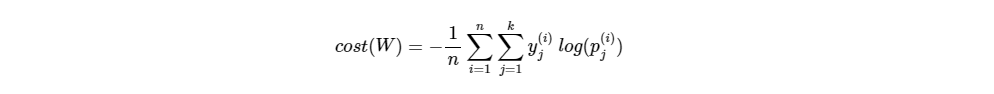

In [39]:
from IPython.display import Image
Image("cross2.PNG")

In [41]:
# 비용함수 구현
# sum은 sum(dim=1), 평균은 mean()으로 구현
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.9681, grad_fn=<MeanBackward0>)


---------------------------------------------------------------------------------------------------------

#### 2. 파이토치로 소프트맥스 비용함수 구현하기(하이-레벨)

##### 1. F.softmax() + torch.log() = F.log_softmax()
- 앞서 소프트맥스 함수의 결과에 로그를 씌울 때는 다음과 같이 소프트맥스 함수의 출력값을 로그 함수의 입력으로 사용했다. 

In [44]:
# low level
torch.log(F.softmax(z, dim=1))

tensor([[-2.0104, -1.3722, -1.5215, -1.9999, -1.3519],
        [-1.4156, -1.2757, -1.9994, -1.8014, -1.7288],
        [-1.4667, -1.9192, -1.8945, -1.2677, -1.6570]], grad_fn=<LogBackward0>)

파이토치에서는 두 개의 함수를 결합한 **F.log_softmax()** 라는 도구 제공

In [46]:
# High level
F.log_softmax(z, dim=1)

tensor([[-2.0104, -1.3722, -1.5215, -1.9999, -1.3519],
        [-1.4156, -1.2757, -1.9994, -1.8014, -1.7288],
        [-1.4667, -1.9192, -1.8945, -1.2677, -1.6570]],
       grad_fn=<LogSoftmaxBackward0>)

##### 2. F.log_softmax(m) + F.nll_loss9) = F.cross_entropy()

In [48]:
# low level
# 첫번째 수식
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.9681, grad_fn=<MeanBackward0>)

torch.log(F.softmax(z, dim=1))을 F.log_softmax()로 대체

In [49]:
# 두번째 수식
(y_one_hot * -F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.9681, grad_fn=<MeanBackward0>)

In [50]:
# High level
# 세번째 수식
F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.9681, grad_fn=<NllLossBackward0>)

- nll : Negative Log Likelihood의 약자로, nll_loss는 F.log_softmax()를 수행한 후에 남은 수식들을 수행한다. 
- 이를 더 간단하게 하면 다음과 같이 사용할 수 있다. 
- F.cross_entropy() : F.log_softmax()와 F.nll_loss()를 포함하고 있다.

In [51]:
# 네번째 수식
F.cross_entropy(z, y)

tensor(1.9681, grad_fn=<NllLossBackward0>)

**F.cross_entropy는 비용 함수에 소프트맥스 함수까지 포함하고 있음을 기억하고 있어야 구현 시 혼동하지 않는다.**